In [1]:
%config InlineBackend.figure_format='retina'
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import matplotlib.colors
import hvplot.pandas
import hvplot

In [2]:
mbox = pd.read_csv('mailboxes/values_device_28002c000747373336373936_mlrcy.csv')
ucon = pd.read_csv('ucon/values_device_1a0031001950483553353620_4yure.csv')
glen = pd.read_csv('glenwood/values_device_2f003a000c47373336373936_00i5i.csv')

def rename_vars(df):
    df['Human readable date'] = pd.DatetimeIndex(df['Human readable date'] )
    df = df.set_index('Human readable date')
    df = df.sort_index()
    # just look at July onward for consistency
    df = df[df.index >= pd.Timestamp('2020-07-01')]
    return df
mbox = rename_vars(mbox)
ucon = rename_vars(ucon)
glen = rename_vars(glen)

In [3]:
aqi = pd.read_csv('ad_viz_plotval_data.csv.xls')
aqi = aqi[aqi['Site Name'] == 'Santa Cruz']
aqi['Date'] = pd.DatetimeIndex(aqi['Date'])
aqi = aqi.set_index('Date')

# Data by time of day
Note that at some locations the number of data points varies throughout the year, leading to the potential for inconsistencies in data analysis. This is likely caused by shading or obscuring of the solar panels. Should consider visiting each counter and checking solar panel and battery.

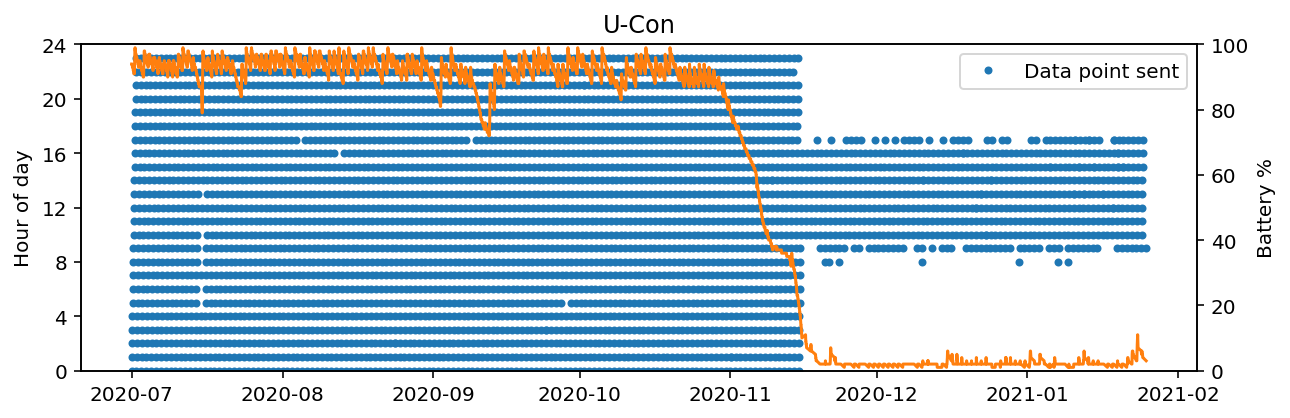

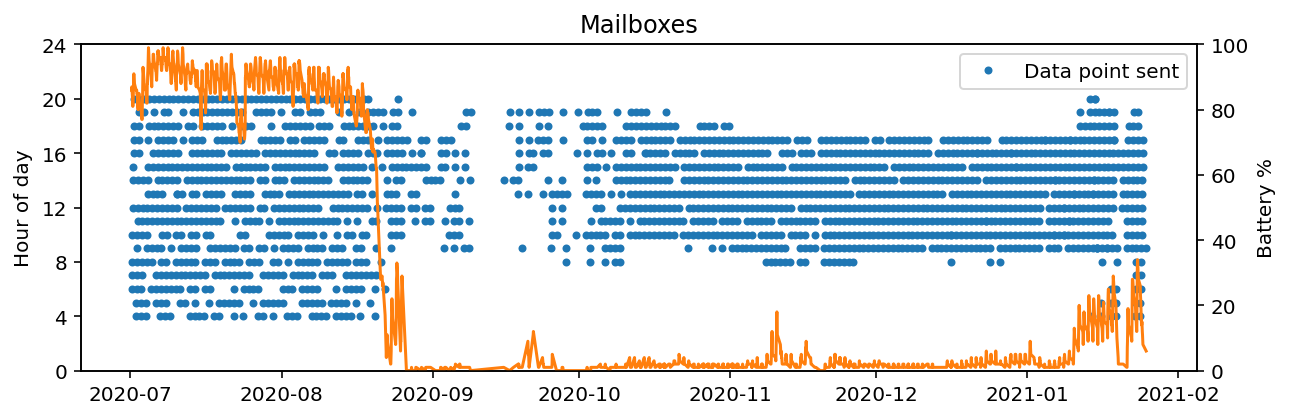

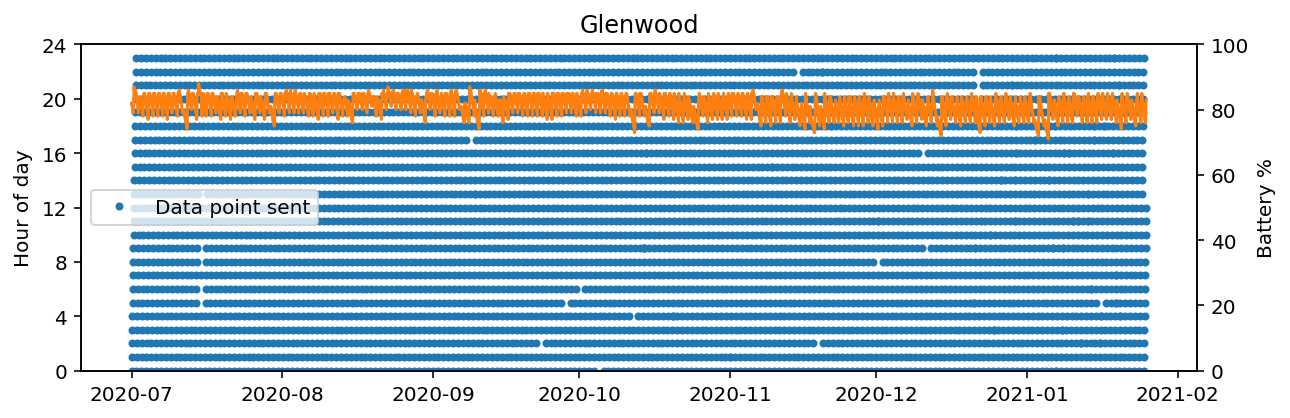

In [4]:
def plot(df, title=None):
    plt.figure(figsize=(10,3))
    plt.plot(df.index, df.index.hour, '.', label='Data point sent')
    plt.legend()
    plt.ylim(0,24)
    plt.yticks(np.arange(0,25,4))
    plt.ylabel('Hour of day')
    plt.twinx()
    plt.plot(df.index, df.battery, c='C1')
    plt.ylim(0,100)
    plt.ylabel('Battery %')
    plt.title(title)
    plt.show()
plot(ucon, 'U-Con')
plot(mbox, 'Mailboxes')
plot(glen, 'Glenwood')

# Daily riders
Start simple: how many riders do we have at each counter?

In [5]:
def plot(df, title=None):
    return df.groupby(df.index.date).max()['daily'].hvplot(label=title)
plot(ucon, title='U-Con') * plot(mbox, title='Mailboxes') * plot(glen, title='Glenwood')

:Overlay
   .Curve.U_hyphen_minus_Con :Curve   [index]   (daily)
   .Curve.Mailboxes          :Curve   [index]   (daily)
   .Curve.Glenwood           :Curve   [index]   (daily)

# Daily riders and AQI (inspired by SeanPaul)
Smoke from the fires severely reduced ridership during August and September.

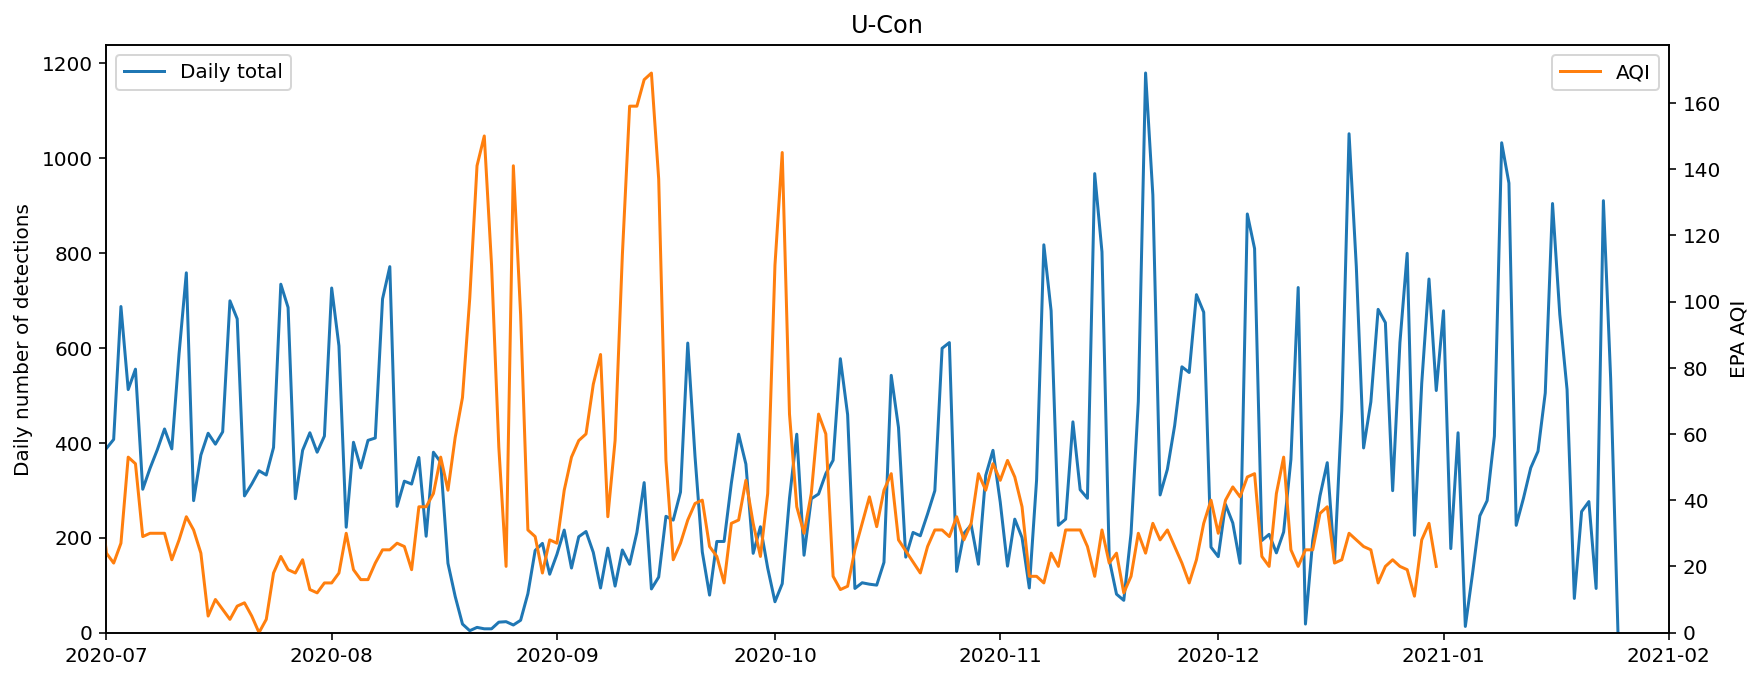

In [6]:
def plot(df, title=None):
    plt.figure(figsize=(14,6))
    df.groupby(df.index.date).max()['daily'].plot(label='Daily total')
    plt.ylabel('Daily number of detections')
    plt.ylim(ymin=0)
    plt.legend(loc='upper left')
    plt.twinx()
    aqi['DAILY_AQI_VALUE'].plot(color='C1', label='AQI')
    plt.legend(loc='upper right')
    plt.xlim('2020-07', '2021-02')
    plt.ylim(ymin=0)
    plt.title(title)
    plt.ylabel('EPA AQI')
    
plot(ucon, title='U-Con')
# plot(mbox, title='Mailboxes')
# plot(glen, title='Glenwood')

# Riders by day of week
Ridership is unsurprisingly highest on the weekend days. This pattern is not as strong at West Glenwood.

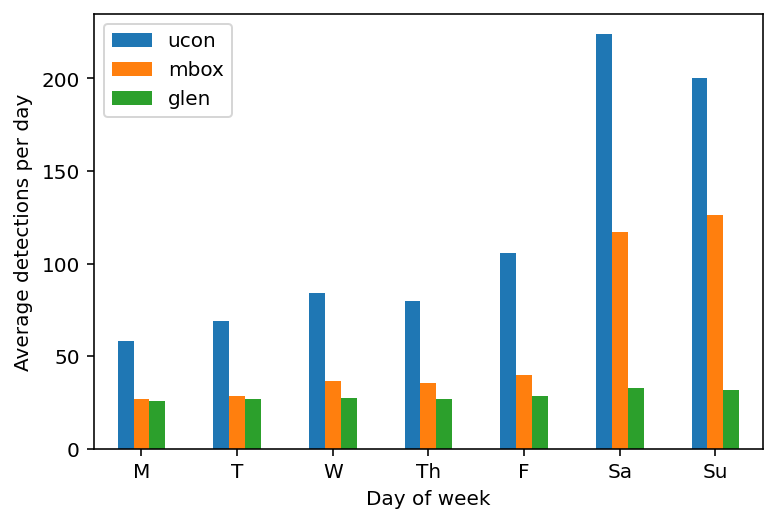

In [7]:
dfnew = pd.DataFrame()
def makenew(df):
    return df.groupby(df.index.dayofweek).mean()['daily']
dfnew['ucon'] = makenew(ucon)
dfnew['mbox'] = makenew(mbox)
dfnew['glen'] = makenew(glen)

# plt.figure(figsize=(14,5))
dfnew.plot.bar()
plt.xlabel('Day of week')
plt.xticks(np.arange(7), ['M', 'T', 'W' , 'Th', 'F', 'Sa', 'Su'], rotation=0)
plt.ylabel('Average detections per day')
plt.show()

# Riders by month
Complex patterns here may be exacerbated by inconsistent data transmission over time.

In [8]:
dfnew = pd.DataFrame()
def makenew(df):
    newdf = df.groupby(df.index.month).mean()['daily']
    return newdf / newdf.max()
dfnew['ucon'] = makenew(ucon)
dfnew['mbox'] = makenew(mbox)
dfnew['glen'] = makenew(glen)

dfnew.hvplot.bar(stacked=False, rot=60, xlabel='Month', ylabel='Fraction of max daily detections')

:Bars   [Human readable date,Variable]   (value)

# Riders by hour of day
Complex patterns here may be exacerbated by inconsistent data transmission over time.

In [9]:
dfnew = pd.DataFrame()
def makenew(df):
    newdf = df.groupby(df.index.hour).mean()['hourly']
    return newdf / newdf.max()
dfnew['ucon'] = makenew(ucon)
dfnew['mbox'] = makenew(mbox)
dfnew['glen'] = makenew(glen)
dfnew = dfnew[(dfnew.index > 8) & (dfnew.index < 18)]
dfnew.hvplot.bar(stacked=False, rot=60, xlabel='Hour of day', ylabel='Fraction of max hourly detections')

:Bars   [Human readable date,Variable]   (value)

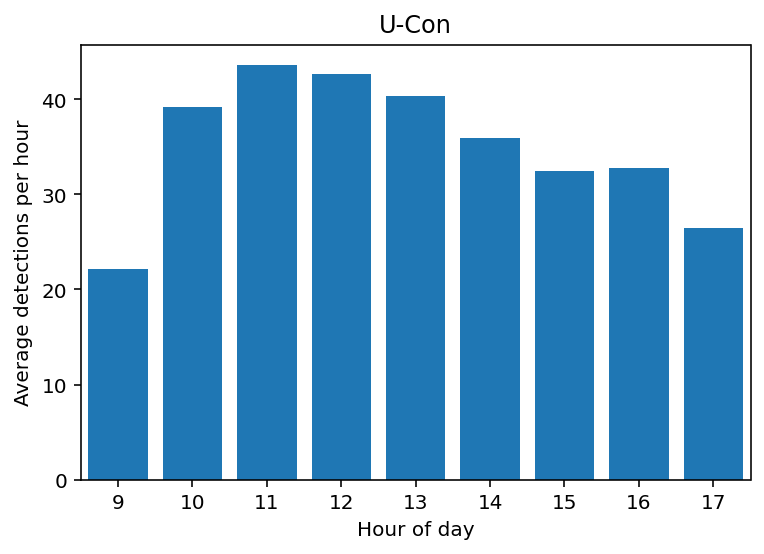

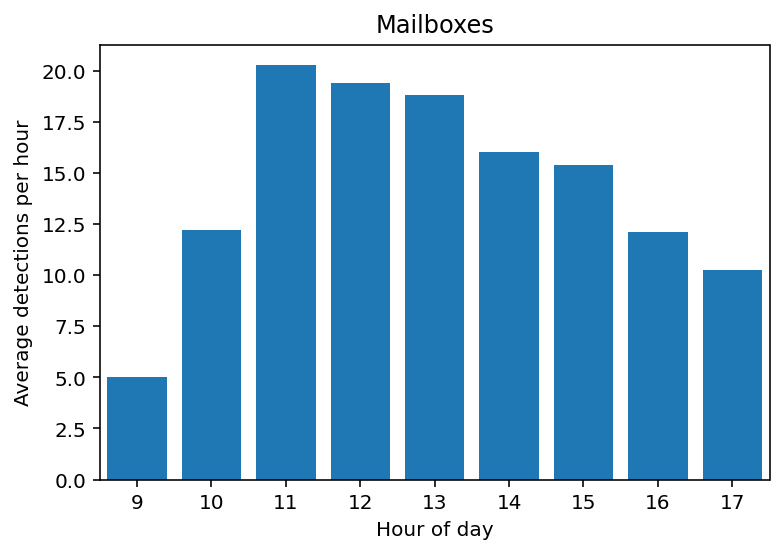

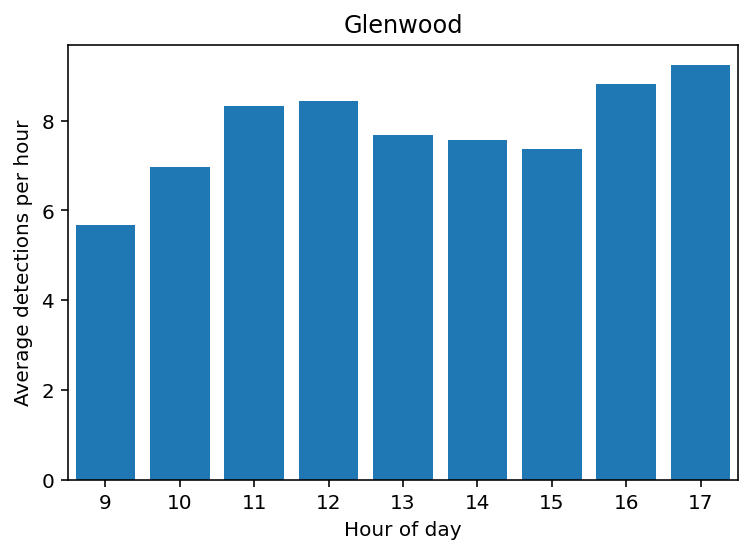

In [10]:
def plot(df, title=None):
    gb = df.groupby(df.index.hour)
    gbm = gb.mean()

    plt.bar(gbm.index, gbm.hourly)

    plt.xticks(np.arange(0,25))
    plt.xlim(8.5,17.5)
    plt.xlabel('Hour of day')
    plt.ylabel('Average detections per hour')
    plt.title(title)
    plt.show()
plot(ucon, title='U-Con')
plot(mbox, 'Mailboxes')
plot(glen, 'Glenwood')

# Total cumulative riders
Note decrease in slope during August fires.

In [11]:
def plot(df, title=None):
    return df.hourly.cumsum().hvplot(label=title, ylabel='Cumulative Detections')
plot(ucon, 'U-Con') * plot(mbox, 'Mailboxes') * plot(glen, 'Glenwood')

:Overlay
   .Curve.U_hyphen_minus_Con :Curve   [Human readable date]   (hourly)
   .Curve.Mailboxes          :Curve   [Human readable date]   (hourly)
   .Curve.Glenwood           :Curve   [Human readable date]   (hourly)

# Total riders by day and week of year
Weekends are popular, especially around Thanksgiving.

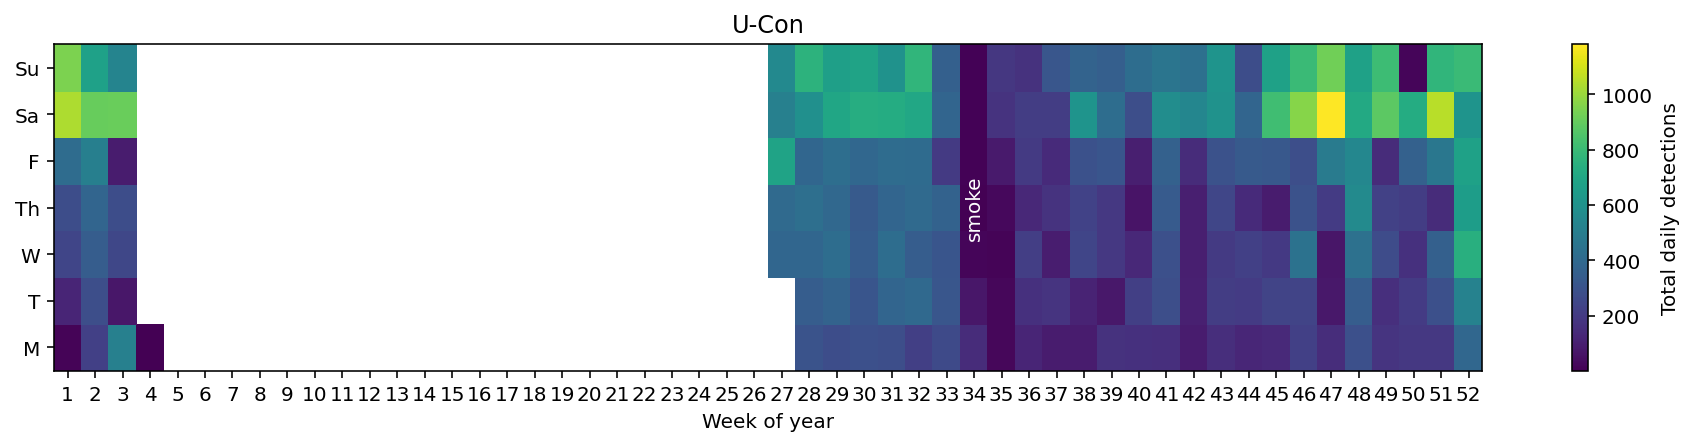

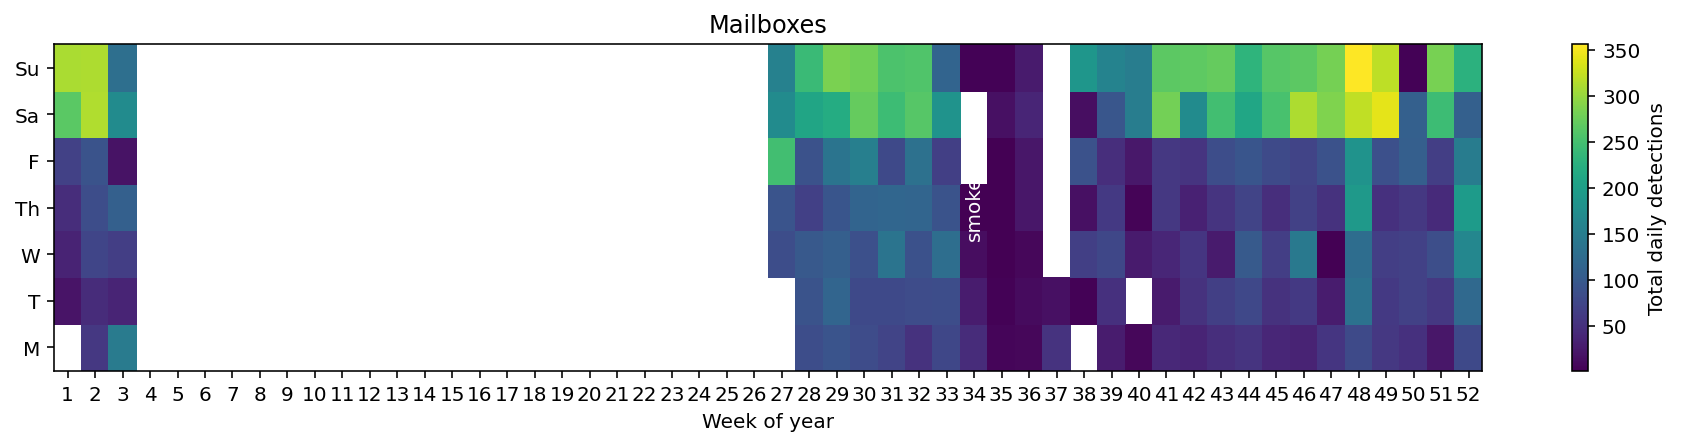

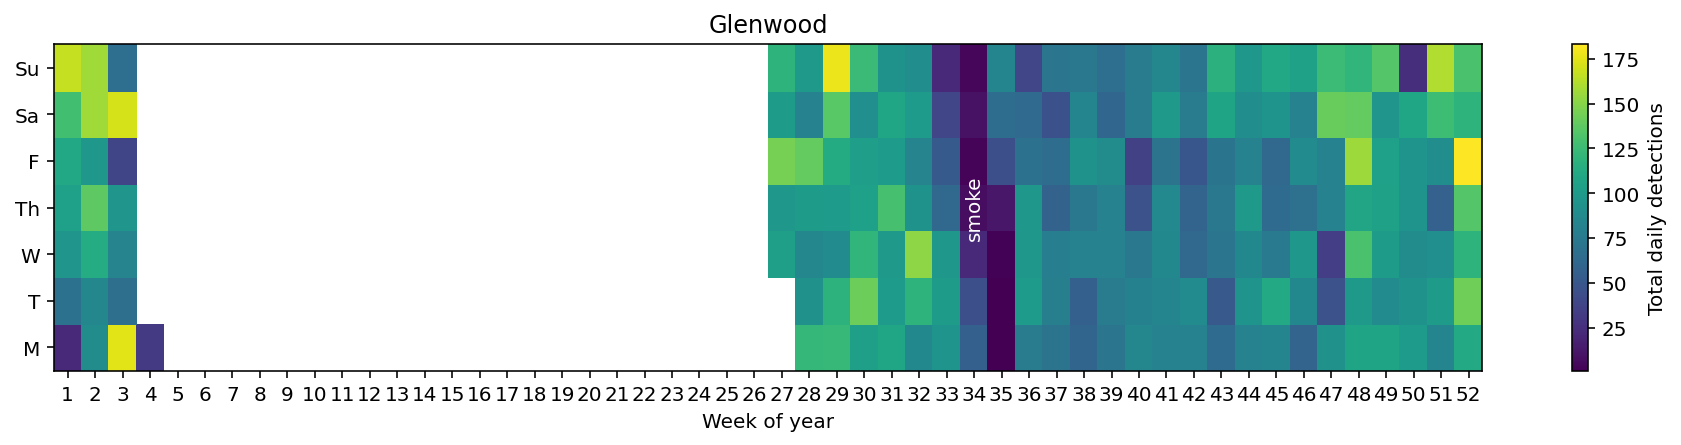

In [12]:
def plot(df, title=None):
    bs = scipy.stats.binned_statistic_2d(df.index.dayofweek, 
                                         df.index.weekofyear, 
                                         df.daily, statistic='max', bins=(np.arange(8), np.arange(1,54)),
                                        )
    bs.statistic[bs.statistic == 0] = np.nan
    plt.figure(figsize=(16,3))
    days = np.arange(8) + 0.5
    weeks = np.arange(1, 54) - 0.5
    plt.pcolormesh(weeks, days, bs.statistic,)#norm=matplotlib.colors.LogNorm())
    plt.yticks(np.arange(1,8), ['M', 'T', 'W' , 'Th', 'F', 'Sa', 'Su'])
    plt.xticks(np.arange(1,53))
    plt.text(34,4, 'smoke', color='w', ha='center', va='center', rotation=90)
    plt.colorbar(label='Total daily detections')
    plt.xlabel('Week of year')
    plt.title(title)
    plt.show()
plot(ucon, 'U-Con')
plot(mbox, 'Mailboxes')
plot(glen, 'Glenwood')